# [Datasets] - Thesis Notebook

This notebook will contain examination and pre-cleaning of the three candidate datasets by producing a standardized dataset file for each of the datasets.

# 1. Importing Libraries

Importing the necessary libraries for dataset parsing, manipulation, and processing.

Included in this are examples of ML related libraries that might be used in the future segments of the study.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

start_time = time.time()

#Evaluation and Testing Systems
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

#ML Models
from sklearn.ensemble import AdaBoostClassifier #AdaBoost
import xgboost as xgb #XGBoost; Install via pip first
import lightgbm as lgb #LightGBM; pip install lightgbm

# 2. Importing Raw Datasets

Importing raw datasets as downloaded from their respective sources.

In [2]:
import threading
malbehavd = None
og_oliveira = None
og_catak = None
def read_malbd():
    global malbehavd
    malbehavd = pd.read_csv("../Datasets/MalBehavD_2022/MalBehavD-V1-dataset.csv")
def read_oliveira():
    global og_oliveira
    og_oliveira = pd.read_csv("../Datasets/Oliveira_2019/dynamic_api_call_sequence_per_malware_100_0_306.csv")
def read_catak():
    global og_catak
    og_catak = pd.read_csv("../Datasets/Catak_etal_2021/Original/all_analysis_data.csv", low_memory=False)
malbd_thread = threading.Thread(target=read_malbd)
oliveira_thread = threading.Thread(target=read_oliveira)
catak_thread = threading.Thread(target=read_catak)
malbd_thread.start()
oliveira_thread.start()
catak_thread.start()
malbd_thread.join()
oliveira_thread.join()
catak_thread.join()

## 2.1. MalBehavD-V1

**Dataset URL:** https://github.com/mpasco/MalbehavD-V1

In [3]:
print("Dataframe Shape:", malbehavd.shape)
print("Dataframe Element Size:", malbehavd.size)

Dataframe Shape: (2570, 177)
Dataframe Element Size: 454890


## 2.2. Oliveira Dataset
**Dataset URL:** https://ieee-dataport.org/open-access/malware-analysis-datasets-api-call-sequences

**Modification:** The version of the dataset here was converted from the

In [4]:
print("Dataframe Shape:", og_oliveira.shape)
print("Dataframe Element Size:", og_oliveira.size)

Dataframe Shape: (43876, 102)
Dataframe Element Size: 4475352


## 2.3. Catak (2021)

**Dataset URL:** https://github.com/ocatak/malware_api_class/

**Note:** The Catak Dataset is designed more for malware classification than detection, hence the first column for the pre-cleaned dataset is designated as a the malware type column.

In [5]:
print("Dataframe Shape:", og_catak.shape)
print("Dataframe Element Size:", og_catak.size)

Dataframe Shape: (7106, 1)
Dataframe Element Size: 7106


# 3. Examining & Cleaning of Datasets

## 3.1. MalBehavD-V1

**Dataset URL:** https://github.com/mpasco/MalbehavD-V1

### 3.1.1. Examining Raw Dataset

In [6]:
malbehavd.head()

,sha256,labels,0,1,2,3,4,5,6,7,...,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,5c18291c481a192ed5003084dab2d8a117fd3736359218...,0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4683faf3da550ffb594cf5513c4cbb34f64df85f27fd1c...,0,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9a0aea1c7290031d7c3429d0e921f107282cc6eab854ee...,0,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e0f3e4d5f50afd9c31e51dd9941c5a52d57c7c524f5d11...,0,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ec2b6d29992f13e74015ff0b129150b4afae15c593e4b7...,0,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.1.2. Pre-Cleaning Dataset

**3.1.2.1 Pre-Cleaning**

In [7]:
#FIXES MISSING CSV HEADER DATA
def get_header(size):
    size -= 2
    output = "sha256,malware,"
    for i in range(size):
        output += str(i)
        if i < size-1:
            output += ","
    return output
dataset = open("../Datasets/MalBehavD_2022/Original/MalBehavD-V1-dataset.csv", mode='r') #Change to: os.getcwd()+"\\Original\\"+"MalBehavD-V1-dataset.csv" for terminal use
new_dataset = open("./Cache/MalbehavD_Cleaned.csv", mode="w") #Change to: MalbehavD_Cleaned.csv for terminal use
breadth = 0
first_row = True
print("Rebuilding dataset...")
for row_data in dataset:
    if first_row:
        breadth = len(row_data.replace('\n','').split(','))
        first_row = False
        new_dataset.write(get_header(breadth) + "\n")
    else:
        new_dataset.write(row_data)
print("Flushing file...")
new_dataset.flush()
print("Closing file...")
new_dataset.close()
print("Pre-cleaning for MalbehavD-V1 Completed!")
dataset = None
labels = None
new_dataset = None

Rebuilding dataset...
Flushing file...
Closing file...
Pre-cleaning for MalbehavD-V1 Completed!


**3.1.2.2 Rearranging Columns**

Only the first two columns will be set as non-API call related.

In [8]:
malbehavd = pd.read_csv("./Cache/MalbehavD_Cleaned.csv")
mal_col = malbehavd.pop('malware')
malbehavd.insert(1, mal_col.name, mal_col)
malbehavd.head()

,sha256,malware,0,1,2,3,4,5,6,7,...,165,166,167,168,169,170,171,172,173,174
0,5c18291c481a192ed5003084dab2d8a117fd3736359218...,0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4683faf3da550ffb594cf5513c4cbb34f64df85f27fd1c...,0,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9a0aea1c7290031d7c3429d0e921f107282cc6eab854ee...,0,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e0f3e4d5f50afd9c31e51dd9941c5a52d57c7c524f5d11...,0,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ec2b6d29992f13e74015ff0b129150b4afae15c593e4b7...,0,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.1.3. Examining API calls

**3.1.3.1 Examining API calls in MalbehavD-V1**

In [9]:
featr = malbehavd.iloc[:, 2:177]
featr.head()

,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtClose,GetFileVersionInfoSizeW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,NtQueryValueKey,RegCloseKey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,RegQueryValueExW,NtMapViewOfSection,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,LdrGetDllHandle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,NtQueryAttributesFile,LdrGetDllHandle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**3.1.3.2. Unique API calls on MalBehavD-V1**

In [10]:
combined_summary = []
featr['summary'] = featr.values.tolist()
for i in range(featr['summary'].shape[0]):
    length = len(featr['summary'].loc[i])
    for j in range(length-1):
        combined_summary.append(featr['summary'].loc[i][j])
print("combined_summary:", len(combined_summary))
malbd_featr = pd.Series(combined_summary).dropna().drop_duplicates().reset_index()
malbd_featr.rename(columns={'index': 'index', 0: 'api_calls'}, inplace=True)
malbd_featr.sort_values(inplace=True, by='api_calls')
malbd_featr.drop(axis=1, labels="index", inplace=True)

#Writing to own file
f = open("./Features/MalbehavD_Features.txt", mode="w")
f.write(str(malbd_featr['api_calls'].tolist()).replace('[','').replace(']','').replace(',','\n').replace('\'','').replace(' ',''))
f.flush()
f.close()

malbd_featr.head()

combined_summary: 447180


,api_calls
142,CertControlStore
245,CertCreateCertificateContext
138,CertOpenStore
277,CertOpenSystemStoreW
89,CoCreateInstance


**3.1.3.3. Frequency of API calls in the Dataset**

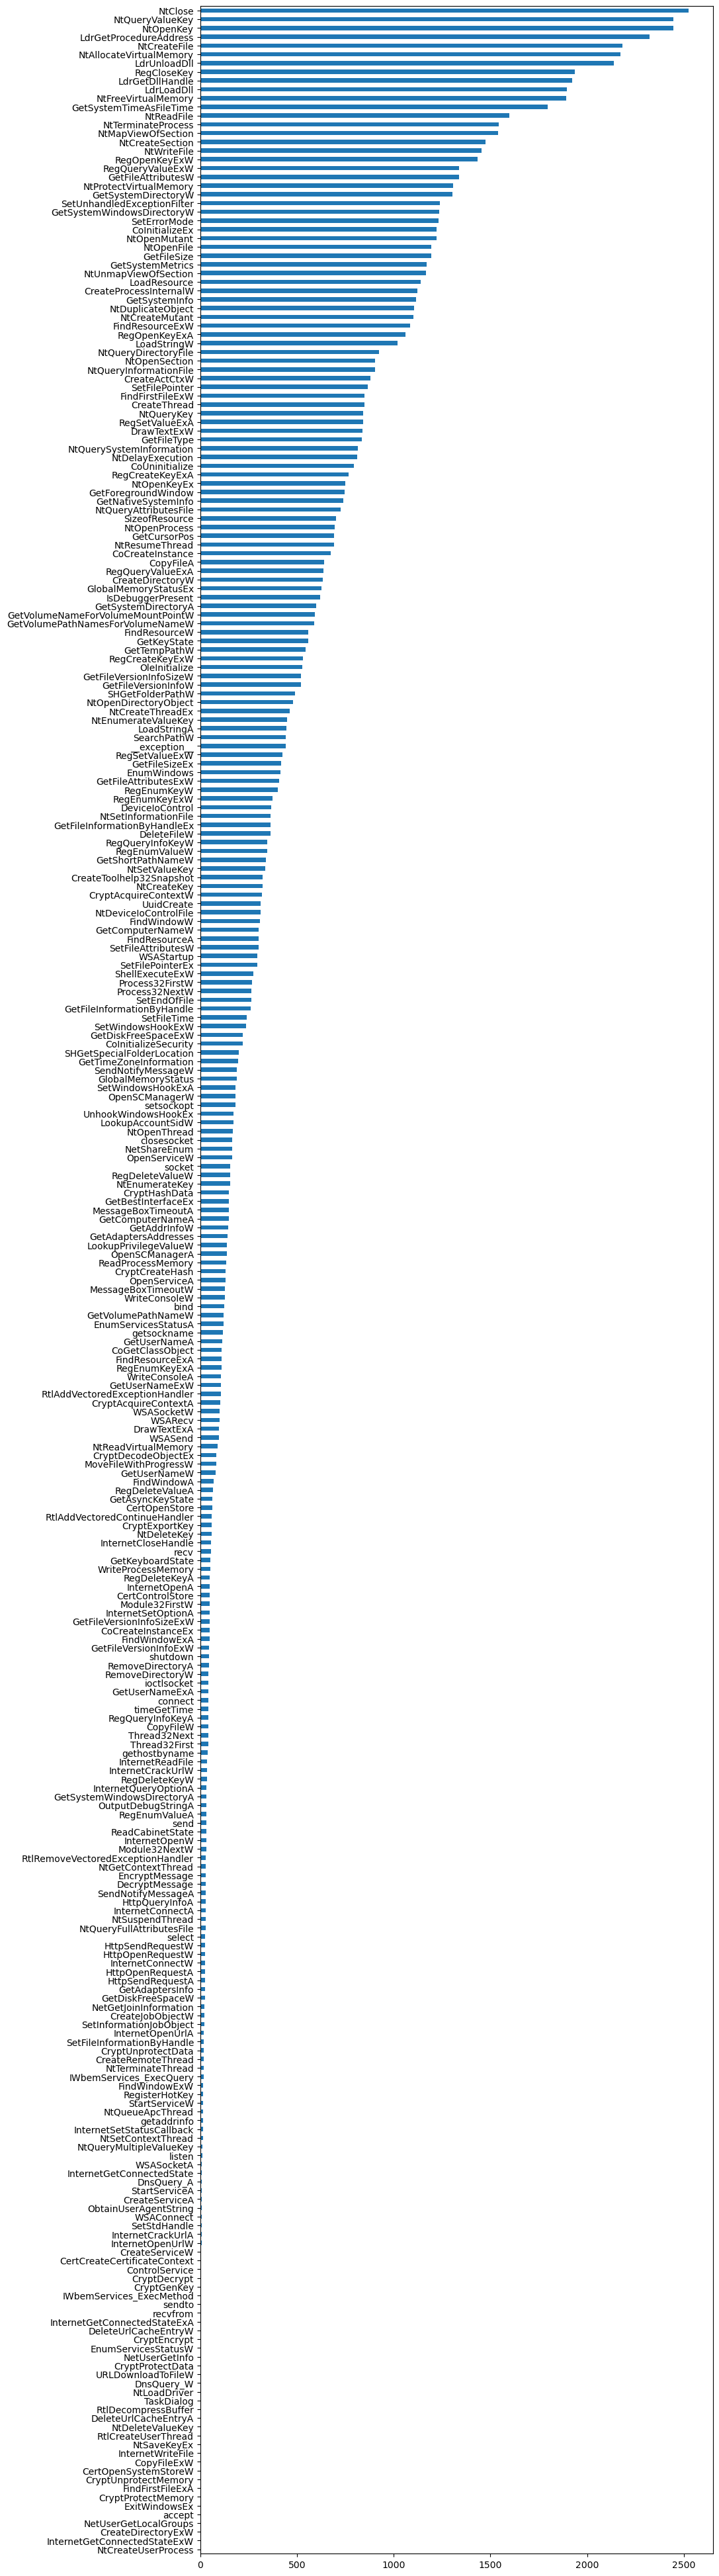

In [11]:
api_frequency = pd.DataFrame(combined_summary)[0].value_counts(ascending=True)
api_frequency.plot(kind='barh', figsize=(10,50))
print(api_frequency.to_string(), file=open('./Frequency/MalbehavD_Freq.txt', mode='w'))

## 3.2. Oliveira Dataset

**Dataset URL:** https://ieee-dataport.org/open-access/malware-analysis-datasets-api-call-sequences

**Modification:** The version of the dataset here was converted from the

### 3.2.1. Examining Raw Dataset

In [12]:
og_oliveira.head()

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,81,240,117,71,297,135,171,215,35,1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,112,123,65,113,112,1
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,208,302,208,302,187,208,302,228,302,1
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,209,260,40,209,260,141,260,141,260,1


In [13]:
og_oliveira = None

### 3.2.2. Pre-Cleaning Dataset

**3.2.2.1. Pre-Cleaning**

In [14]:
#CONVERTS THE NUMBER NOTATION OF API CALLS IN OLVIEIRA (2019) DATASET TO ACTUAL API CALLS
def get_header(col_size):
    header = ""
    header = "hash," #'hash' is possibly MD5 as per Cyberchef 
    for i in range(col_size-2):
        header += str(i)+","
    header += "malware\n"
    return header
dataset = open("../Datasets/Oliveira_2019/Original/dynamic_api_call_sequence_per_malware_100_0_306.csv", mode="r") #Change to: os.getcwd()+"\\Original\\"+"dynamic_api_call_sequence_per_malware_100_0_306.csv" for terminal use
new_dataset = open("./Cache/Oliveira_Cleaned.csv", mode="w+") #Change to: Oliveira_Cleaned.csv for terminal use
oliveira_idx = ['NtOpenThread', 'ExitWindowsEx', 'FindResourceW', 'CryptExportKey', 'CreateRemoteThreadEx', 'MessageBoxTimeoutW', 'InternetCrackUrlW', 'StartServiceW', 'GetFileSize', 'GetVolumeNameForVolumeMountPointW', 'GetFileInformationByHandle', 'CryptAcquireContextW', 'RtlDecompressBuffer', 'SetWindowsHookExA', 'RegSetValueExW', 'LookupAccountSidW', 'SetUnhandledExceptionFilter', 'InternetConnectA', 'GetComputerNameW', 'RegEnumValueA', 'NtOpenFile', 'NtSaveKeyEx', 'HttpOpenRequestA', 'recv', 'GetFileSizeEx', 'LoadStringW', 'SetInformationJobObject', 'WSAConnect', 'CryptDecrypt', 'GetTimeZoneInformation', 'InternetOpenW', 'CoInitializeEx', 'CryptGenKey', 'GetAsyncKeyState', 'NtQueryInformationFile', 'GetSystemMetrics', 'NtDeleteValueKey', 'NtOpenKeyEx', 'sendto', 'IsDebuggerPresent', 'RegQueryInfoKeyW', 'NetShareEnum', 'InternetOpenUrlW', 'WSASocketA', 'CopyFileExW', 'connect', 'ShellExecuteExW', 'SearchPathW', 'GetUserNameA', 'InternetOpenUrlA', 'LdrUnloadDll', 'EnumServicesStatusW', 'EnumServicesStatusA', 'WSASend', 'CopyFileW', 'NtDeleteFile', 'CreateActCtxW', 'timeGetTime', 'MessageBoxTimeoutA', 'CreateServiceA', 'FindResourceExW', 'WSAAccept', 'InternetConnectW', 'HttpSendRequestA', 'GetVolumePathNameW', 'RegCloseKey', 'InternetGetConnectedStateExW', 'GetAdaptersInfo', 'shutdown', 'NtQueryMultipleValueKey', 'NtQueryKey', 'GetSystemWindowsDirectoryW', 'GlobalMemoryStatusEx', 'GetFileAttributesExW', 'OpenServiceW', 'getsockname', 'LoadStringA', 'UnhookWindowsHookEx', 'NtCreateUserProcess', 'Process32NextW', 'CreateThread', 'LoadResource', 'GetSystemTimeAsFileTime', 'SetStdHandle', 'CoCreateInstanceEx', 'GetSystemDirectoryA', 'NtCreateMutant', 'RegCreateKeyExW', 'IWbemServices_ExecQuery', 'NtDuplicateObject', 'Thread32First', 'OpenSCManagerW', 'CreateServiceW', 'GetFileType', 'MoveFileWithProgressW', 'NtDeviceIoControlFile', 'GetFileInformationByHandleEx', 'CopyFileA', 'NtLoadKey', 'GetNativeSystemInfo', 'NtOpenProcess', 'CryptUnprotectMemory', 'InternetWriteFile', 'ReadProcessMemory', 'gethostbyname', 'WSASendTo', 'NtOpenSection', 'listen', 'WSAStartup', 'socket', 'OleInitialize', 'FindResourceA', 'RegOpenKeyExA', 'RegEnumKeyExA', 'NtQueryDirectoryFile', 'CertOpenSystemStoreW', 'ControlService', 'LdrGetProcedureAddress', 'GlobalMemoryStatus', 'NtSetInformationFile', 'OutputDebugStringA', 'GetAdaptersAddresses', 'CoInitializeSecurity', 'RegQueryValueExA', 'NtQueryFullAttributesFile', 'DeviceIoControl', '__anomaly__', 'DeleteFileW', 'GetShortPathNameW', 'NtGetContextThread', 'GetKeyboardState', 'RemoveDirectoryA', 'InternetSetStatusCallback', 'NtResumeThread', 'SetFileInformationByHandle', 'NtCreateSection', 'NtQueueApcThread', 'accept', 'DecryptMessage', 'GetUserNameExW', 'SizeofResource', 'RegQueryValueExW', 'SetWindowsHookExW', 'HttpOpenRequestW', 'CreateDirectoryW', 'InternetOpenA', 'GetFileVersionInfoExW', 'FindWindowA', 'closesocket', 'RtlAddVectoredExceptionHandler', 'IWbemServices_ExecMethod', 'GetDiskFreeSpaceExW', 'TaskDialog', 'WriteConsoleW', 'CryptEncrypt', 'WSARecvFrom', 'NtOpenMutant', 'CoGetClassObject', 'NtQueryValueKey', 'NtDelayExecution', 'select', 'HttpQueryInfoA', 'GetVolumePathNamesForVolumeNameW', 'RegDeleteValueW', 'InternetCrackUrlA', 'OpenServiceA', 'InternetSetOptionA', 'CreateDirectoryExW', 'bind', 'NtShutdownSystem', 'DeleteUrlCacheEntryA', 'NtMapViewOfSection', 'LdrGetDllHandle', 'NtCreateKey', 'GetKeyState', 'CreateRemoteThread', 'NtEnumerateValueKey', 'SetFileAttributesW', 'NtUnmapViewOfSection', 'RegDeleteValueA', 'CreateJobObjectW', 'send', 'NtDeleteKey', 'SetEndOfFile', 'GetUserNameExA', 'GetComputerNameA', 'URLDownloadToFileW', 'NtFreeVirtualMemory', 'recvfrom', 'NtUnloadDriver', 'NtTerminateThread', 'CryptUnprotectData', 'NtCreateThreadEx', 'DeleteService', 'GetFileAttributesW', 'GetFileVersionInfoSizeExW', 'OpenSCManagerA', 'WriteProcessMemory', 'GetSystemInfo', 'SetFilePointer', 'Module32FirstW', 'ioctlsocket', 'RegEnumKeyW', 'RtlCompressBuffer', 'SendNotifyMessageW', 'GetAddrInfoW', 'CryptProtectData', 'Thread32Next', 'NtAllocateVirtualMemory', 'RegEnumKeyExW', 'RegSetValueExA', 'DrawTextExA', 'CreateToolhelp32Snapshot', 'FindWindowW', 'CoUninitialize', 'NtClose', 'WSARecv', 'CertOpenStore', 'InternetGetConnectedState', 'RtlAddVectoredContinueHandler', 'RegDeleteKeyW', 'SHGetSpecialFolderLocation', 'CreateProcessInternalW', 'NtCreateDirectoryObject', 'EnumWindows', 'DrawTextExW', 'RegEnumValueW', 'SendNotifyMessageA', 'NtProtectVirtualMemory', 'NetUserGetLocalGroups', 'GetUserNameW', 'WSASocketW', 'getaddrinfo', 'AssignProcessToJobObject', 'SetFileTime', 'WriteConsoleA', 'CryptDecodeObjectEx', 'EncryptMessage', 'system', 'NtSetContextThread', 'LdrLoadDll', 'InternetGetConnectedStateExA', 'RtlCreateUserThread', 'GetCursorPos', 'Module32NextW', 'RegCreateKeyExA', 'NtLoadDriver', 'NetUserGetInfo', 'SHGetFolderPathW', 'GetBestInterfaceEx', 'CertControlStore', 'StartServiceA', 'NtWriteFile', 'Process32FirstW', 'NtReadVirtualMemory', 'GetDiskFreeSpaceW', 'GetFileVersionInfoW', 'FindFirstFileExW', 'FindWindowExW', 'GetSystemWindowsDirectoryA', 'RegOpenKeyExW', 'CoCreateInstance', 'NtQuerySystemInformation', 'LookupPrivilegeValueW', 'NtReadFile', 'ReadCabinetState', 'GetForegroundWindow', 'InternetCloseHandle', 'FindWindowExA', 'ObtainUserAgentString', 'CryptCreateHash', 'GetTempPathW', 'CryptProtectMemory', 'NetGetJoinInformation', 'NtOpenKey', 'GetSystemDirectoryW', 'DnsQuery_A', 'RegQueryInfoKeyA', 'NtEnumerateKey', 'RegisterHotKey', 'RemoveDirectoryW', 'FindFirstFileExA', 'CertOpenSystemStoreA', 'NtTerminateProcess', 'NtSetValueKey', 'CryptAcquireContextA', 'SetErrorMode', 'UuidCreate', 'RtlRemoveVectoredExceptionHandler', 'RegDeleteKeyA', 'setsockopt', 'FindResourceExA', 'NtSuspendThread', 'GetFileVersionInfoSizeW', 'NtOpenDirectoryObject', 'InternetQueryOptionA', 'InternetReadFile', 'NtCreateFile', 'NtQueryAttributesFile', 'HttpSendRequestW', 'CryptHashMessage', 'CryptHashData', 'NtWriteVirtualMemory', 'SetFilePointerEx', 'CertCreateCertificateContext', 'DeleteUrlCacheEntryW', '__exception__']
oliveira_idx.sort()
depth = 0
breadth = 0
for r in dataset:
    depth += 1
    if len(r.split(',')) > breadth:
        breadth = len(r.split(','))
dataset.seek(0, 0)
ctr = 0
print(f"Converting #s to API Calls...")
first_row = True
for row_data in dataset:
    if first_row:
        new_dataset.write(get_header(breadth))
        first_row = False
    else:
        new_row = row_data.replace('\n','').split(',')
        for col in range(1,len(new_row)-1):
            new_row[col] = oliveira_idx[int(new_row[col])]
        new_dataset.write(','.join(new_row)+"\n")
    ctr += 1
print("Flushing file...")
new_dataset.flush()
print("Closing file...")
new_dataset.close()
print("Pre-cleaning for Oliveira Completed!")
dataset = None
labels = None
new_dataset = None

Converting #s to API Calls...
Flushing file...
Closing file...
Pre-cleaning for Oliveira Completed!


**3.2.2.2. Converting numeric API calls to actual API call strings**

In [15]:
oliveira = pd.read_csv("./Cache/Oliveira_Cleaned.csv")
mal_col = oliveira.pop('malware')
oliveira.insert(1, mal_col.name, mal_col)
oliveira.head()

,hash,malware,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,071e8c3f8922e186e57548cd4c703a5d,1,HttpSendRequestA,WSAAccept,NtCreateSection,Process32NextW,WSAAccept,NtCreateSection,Process32NextW,recvfrom,...,InternetConnectA,GetComputerNameW,recv,LdrGetProcedureAddress,NtLoadDriver,Process32NextW,CryptHashData,OleInitialize,FindFirstFileExW,GetComputerNameW
1,33f8e6d08a6aae939f25a8e0d63dd523,1,GetFileVersionInfoExW,OleInitialize,NtQueryKey,OleInitialize,NtLoadKey,InternetConnectA,NtLoadKey,InternetConnectA,...,FindResourceW,GetFileType,RemoveDirectoryW,InternetConnectA,GetComputerNameW,recv,LdrGetProcedureAddress,NtLoadDriver,Process32NextW,CryptHashData
2,b68abd064e975e1c6d5f25e748663076,1,CreateActCtxW,HttpOpenRequestW,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,...,InternetGetConnectedStateExW,GetAdaptersAddresses,HttpSendRequestA,InternetGetConnectedStateExW,GetAdaptersAddresses,HttpSendRequestA,InternetGetConnectedStateExW,GetAdaptersAddresses,HttpSendRequestW,HttpSendRequestA
3,72049be7bd30ea61297ea624ae198067,1,GetFileVersionInfoExW,OleInitialize,NtQueryKey,OleInitialize,NtLoadKey,InternetConnectA,NtLoadKey,InternetConnectA,...,Process32NextW,OleInitialize,setsockopt,OleInitialize,setsockopt,NtQueryKey,OleInitialize,setsockopt,RegEnumValueA,setsockopt
4,c9b3700a77facf29172f32df6bc77f48,1,GetFileVersionInfoExW,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,...,CryptUnprotectMemory,OpenSCManagerA,SetStdHandle,CryptUnprotectMemory,OpenSCManagerA,SetStdHandle,LookupAccountSidW,SetStdHandle,LookupAccountSidW,SetStdHandle


### 3.2.3. Examining API calls

**3.2.3.1. Checking expected API calls as per the IEEE page for the dataset.**

In [16]:
#Expected API calls as per https://ieee-dataport.org/open-access/malware-analysis-datasets-api-call-sequences
oli_apis = ['NtOpenThread', 'ExitWindowsEx', 'FindResourceW', 'CryptExportKey', 'CreateRemoteThreadEx', 'MessageBoxTimeoutW', 'InternetCrackUrlW', 'StartServiceW', 'GetFileSize', 'GetVolumeNameForVolumeMountPointW', 'GetFileInformationByHandle', 'CryptAcquireContextW', 'RtlDecompressBuffer', 'SetWindowsHookExA', 'RegSetValueExW', 'LookupAccountSidW', 'SetUnhandledExceptionFilter', 'InternetConnectA', 'GetComputerNameW', 'RegEnumValueA', 'NtOpenFile', 'NtSaveKeyEx', 'HttpOpenRequestA', 'recv', 'GetFileSizeEx', 'LoadStringW', 'SetInformationJobObject', 'WSAConnect', 'CryptDecrypt', 'GetTimeZoneInformation', 'InternetOpenW', 'CoInitializeEx', 'CryptGenKey', 'GetAsyncKeyState', 'NtQueryInformationFile', 'GetSystemMetrics', 'NtDeleteValueKey', 'NtOpenKeyEx', 'sendto', 'IsDebuggerPresent', 'RegQueryInfoKeyW', 'NetShareEnum', 'InternetOpenUrlW', 'WSASocketA', 'CopyFileExW', 'connect', 'ShellExecuteExW', 'SearchPathW', 'GetUserNameA', 'InternetOpenUrlA', 'LdrUnloadDll', 'EnumServicesStatusW', 'EnumServicesStatusA', 'WSASend', 'CopyFileW', 'NtDeleteFile', 'CreateActCtxW', 'timeGetTime', 'MessageBoxTimeoutA', 'CreateServiceA', 'FindResourceExW', 'WSAAccept', 'InternetConnectW', 'HttpSendRequestA', 'GetVolumePathNameW', 'RegCloseKey', 'InternetGetConnectedStateExW', 'GetAdaptersInfo', 'shutdown', 'NtQueryMultipleValueKey', 'NtQueryKey', 'GetSystemWindowsDirectoryW', 'GlobalMemoryStatusEx', 'GetFileAttributesExW', 'OpenServiceW', 'getsockname', 'LoadStringA', 'UnhookWindowsHookEx', 'NtCreateUserProcess', 'Process32NextW', 'CreateThread', 'LoadResource', 'GetSystemTimeAsFileTime', 'SetStdHandle', 'CoCreateInstanceEx', 'GetSystemDirectoryA', 'NtCreateMutant', 'RegCreateKeyExW', 'IWbemServices_ExecQuery', 'NtDuplicateObject', 'Thread32First', 'OpenSCManagerW', 'CreateServiceW', 'GetFileType', 'MoveFileWithProgressW', 'NtDeviceIoControlFile', 'GetFileInformationByHandleEx', 'CopyFileA', 'NtLoadKey', 'GetNativeSystemInfo', 'NtOpenProcess', 'CryptUnprotectMemory', 'InternetWriteFile', 'ReadProcessMemory', 'gethostbyname', 'WSASendTo', 'NtOpenSection', 'listen', 'WSAStartup', 'socket', 'OleInitialize', 'FindResourceA', 'RegOpenKeyExA', 'RegEnumKeyExA', 'NtQueryDirectoryFile', 'CertOpenSystemStoreW', 'ControlService', 'LdrGetProcedureAddress', 'GlobalMemoryStatus', 'NtSetInformationFile', 'OutputDebugStringA', 'GetAdaptersAddresses', 'CoInitializeSecurity', 'RegQueryValueExA', 'NtQueryFullAttributesFile', 'DeviceIoControl', '__anomaly__', 'DeleteFileW', 'GetShortPathNameW', 'NtGetContextThread', 'GetKeyboardState', 'RemoveDirectoryA', 'InternetSetStatusCallback', 'NtResumeThread', 'SetFileInformationByHandle', 'NtCreateSection', 'NtQueueApcThread', 'accept', 'DecryptMessage', 'GetUserNameExW', 'SizeofResource', 'RegQueryValueExW', 'SetWindowsHookExW', 'HttpOpenRequestW', 'CreateDirectoryW', 'InternetOpenA', 'GetFileVersionInfoExW', 'FindWindowA', 'closesocket', 'RtlAddVectoredExceptionHandler', 'IWbemServices_ExecMethod', 'GetDiskFreeSpaceExW', 'TaskDialog', 'WriteConsoleW', 'CryptEncrypt', 'WSARecvFrom', 'NtOpenMutant', 'CoGetClassObject', 'NtQueryValueKey', 'NtDelayExecution', 'select', 'HttpQueryInfoA', 'GetVolumePathNamesForVolumeNameW', 'RegDeleteValueW', 'InternetCrackUrlA', 'OpenServiceA', 'InternetSetOptionA', 'CreateDirectoryExW', 'bind', 'NtShutdownSystem', 'DeleteUrlCacheEntryA', 'NtMapViewOfSection', 'LdrGetDllHandle', 'NtCreateKey', 'GetKeyState', 'CreateRemoteThread', 'NtEnumerateValueKey', 'SetFileAttributesW', 'NtUnmapViewOfSection', 'RegDeleteValueA', 'CreateJobObjectW', 'send', 'NtDeleteKey', 'SetEndOfFile', 'GetUserNameExA', 'GetComputerNameA', 'URLDownloadToFileW', 'NtFreeVirtualMemory', 'recvfrom', 'NtUnloadDriver', 'NtTerminateThread', 'CryptUnprotectData', 'NtCreateThreadEx', 'DeleteService', 'GetFileAttributesW', 'GetFileVersionInfoSizeExW', 'OpenSCManagerA', 'WriteProcessMemory', 'GetSystemInfo', 'SetFilePointer', 'Module32FirstW', 'ioctlsocket', 'RegEnumKeyW', 'RtlCompressBuffer', 'SendNotifyMessageW', 'GetAddrInfoW', 'CryptProtectData', 'Thread32Next', 'NtAllocateVirtualMemory', 'RegEnumKeyExW', 'RegSetValueExA', 'DrawTextExA', 'CreateToolhelp32Snapshot', 'FindWindowW', 'CoUninitialize', 'NtClose', 'WSARecv', 'CertOpenStore', 'InternetGetConnectedState', 'RtlAddVectoredContinueHandler', 'RegDeleteKeyW', 'SHGetSpecialFolderLocation', 'CreateProcessInternalW', 'NtCreateDirectoryObject', 'EnumWindows', 'DrawTextExW', 'RegEnumValueW', 'SendNotifyMessageA', 'NtProtectVirtualMemory', 'NetUserGetLocalGroups', 'GetUserNameW', 'WSASocketW', 'getaddrinfo', 'AssignProcessToJobObject', 'SetFileTime', 'WriteConsoleA', 'CryptDecodeObjectEx', 'EncryptMessage', 'system', 'NtSetContextThread', 'LdrLoadDll', 'InternetGetConnectedStateExA', 'RtlCreateUserThread', 'GetCursorPos', 'Module32NextW', 'RegCreateKeyExA', 'NtLoadDriver', 'NetUserGetInfo', 'SHGetFolderPathW', 'GetBestInterfaceEx', 'CertControlStore', 'StartServiceA', 'NtWriteFile', 'Process32FirstW', 'NtReadVirtualMemory', 'GetDiskFreeSpaceW', 'GetFileVersionInfoW', 'FindFirstFileExW', 'FindWindowExW', 'GetSystemWindowsDirectoryA', 'RegOpenKeyExW', 'CoCreateInstance', 'NtQuerySystemInformation', 'LookupPrivilegeValueW', 'NtReadFile', 'ReadCabinetState', 'GetForegroundWindow', 'InternetCloseHandle', 'FindWindowExA', 'ObtainUserAgentString', 'CryptCreateHash', 'GetTempPathW', 'CryptProtectMemory', 'NetGetJoinInformation', 'NtOpenKey', 'GetSystemDirectoryW', 'DnsQuery_A', 'RegQueryInfoKeyA', 'NtEnumerateKey', 'RegisterHotKey', 'RemoveDirectoryW', 'FindFirstFileExA', 'CertOpenSystemStoreA', 'NtTerminateProcess', 'NtSetValueKey', 'CryptAcquireContextA', 'SetErrorMode', 'UuidCreate', 'RtlRemoveVectoredExceptionHandler', 'RegDeleteKeyA', 'setsockopt', 'FindResourceExA', 'NtSuspendThread', 'GetFileVersionInfoSizeW', 'NtOpenDirectoryObject', 'InternetQueryOptionA', 'InternetReadFile', 'NtCreateFile', 'NtQueryAttributesFile', 'HttpSendRequestW', 'CryptHashMessage', 'CryptHashData', 'NtWriteVirtualMemory', 'SetFilePointerEx', 'CertCreateCertificateContext', 'DeleteUrlCacheEntryW', '__exception__']
oli_apis.sort()
print("# of Expected API Calls", len(oli_apis))

# of Expected API Calls 307


**3.2.3.2. Examining API calls in Oliveira**

In [17]:
featr = oliveira.iloc[:,2:]
featr.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,HttpSendRequestA,WSAAccept,NtCreateSection,Process32NextW,WSAAccept,NtCreateSection,Process32NextW,recvfrom,GetFileAttributesW,OleInitialize,...,InternetConnectA,GetComputerNameW,recv,LdrGetProcedureAddress,NtLoadDriver,Process32NextW,CryptHashData,OleInitialize,FindFirstFileExW,GetComputerNameW
1,GetFileVersionInfoExW,OleInitialize,NtQueryKey,OleInitialize,NtLoadKey,InternetConnectA,NtLoadKey,InternetConnectA,NtLoadKey,InternetConnectA,...,FindResourceW,GetFileType,RemoveDirectoryW,InternetConnectA,GetComputerNameW,recv,LdrGetProcedureAddress,NtLoadDriver,Process32NextW,CryptHashData
2,CreateActCtxW,HttpOpenRequestW,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,...,InternetGetConnectedStateExW,GetAdaptersAddresses,HttpSendRequestA,InternetGetConnectedStateExW,GetAdaptersAddresses,HttpSendRequestA,InternetGetConnectedStateExW,GetAdaptersAddresses,HttpSendRequestW,HttpSendRequestA
3,GetFileVersionInfoExW,OleInitialize,NtQueryKey,OleInitialize,NtLoadKey,InternetConnectA,NtLoadKey,InternetConnectA,NtLoadKey,InternetConnectA,...,Process32NextW,OleInitialize,setsockopt,OleInitialize,setsockopt,NtQueryKey,OleInitialize,setsockopt,RegEnumValueA,setsockopt
4,GetFileVersionInfoExW,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,NtLoadKey,...,CryptUnprotectMemory,OpenSCManagerA,SetStdHandle,CryptUnprotectMemory,OpenSCManagerA,SetStdHandle,LookupAccountSidW,SetStdHandle,LookupAccountSidW,SetStdHandle


**3.2.3.2. Unique API calls on Oliveira**

In [18]:
featr = oliveira.iloc[:, 2:]
combined_summary = []
featr['summary'] = featr.values.tolist()
for i in range(featr['summary'].shape[0]):
    length = len(featr['summary'].loc[i])
    for j in range(length-1):
        combined_summary.append(featr['summary'].loc[i][j])
oli_featr = pd.Series(combined_summary).dropna().drop_duplicates().reset_index()
oli_featr.rename(columns={'index': 'index', 0: 'api_calls'}, inplace=True)
oli_featr.sort_values(inplace=True, by='api_calls')
oli_featr.drop(axis=1, labels="index", inplace=True)

#Writing to own file
f = open("./Features/Oliveira_Features.txt", mode="w")
f.write(str(oli_featr['api_calls'].tolist()).replace('[','').replace(']','').replace(',','\n').replace('\'','').replace(' ',''))
f.flush()
f.close()

oli_featr.head()

,api_calls
157,AssignProcessToJobObject
57,CertCreateCertificateContext
225,CertOpenStore
176,CertOpenSystemStoreW
205,CoCreateInstance


**3.2.3.3. Frequency of API calls in the Dataset**

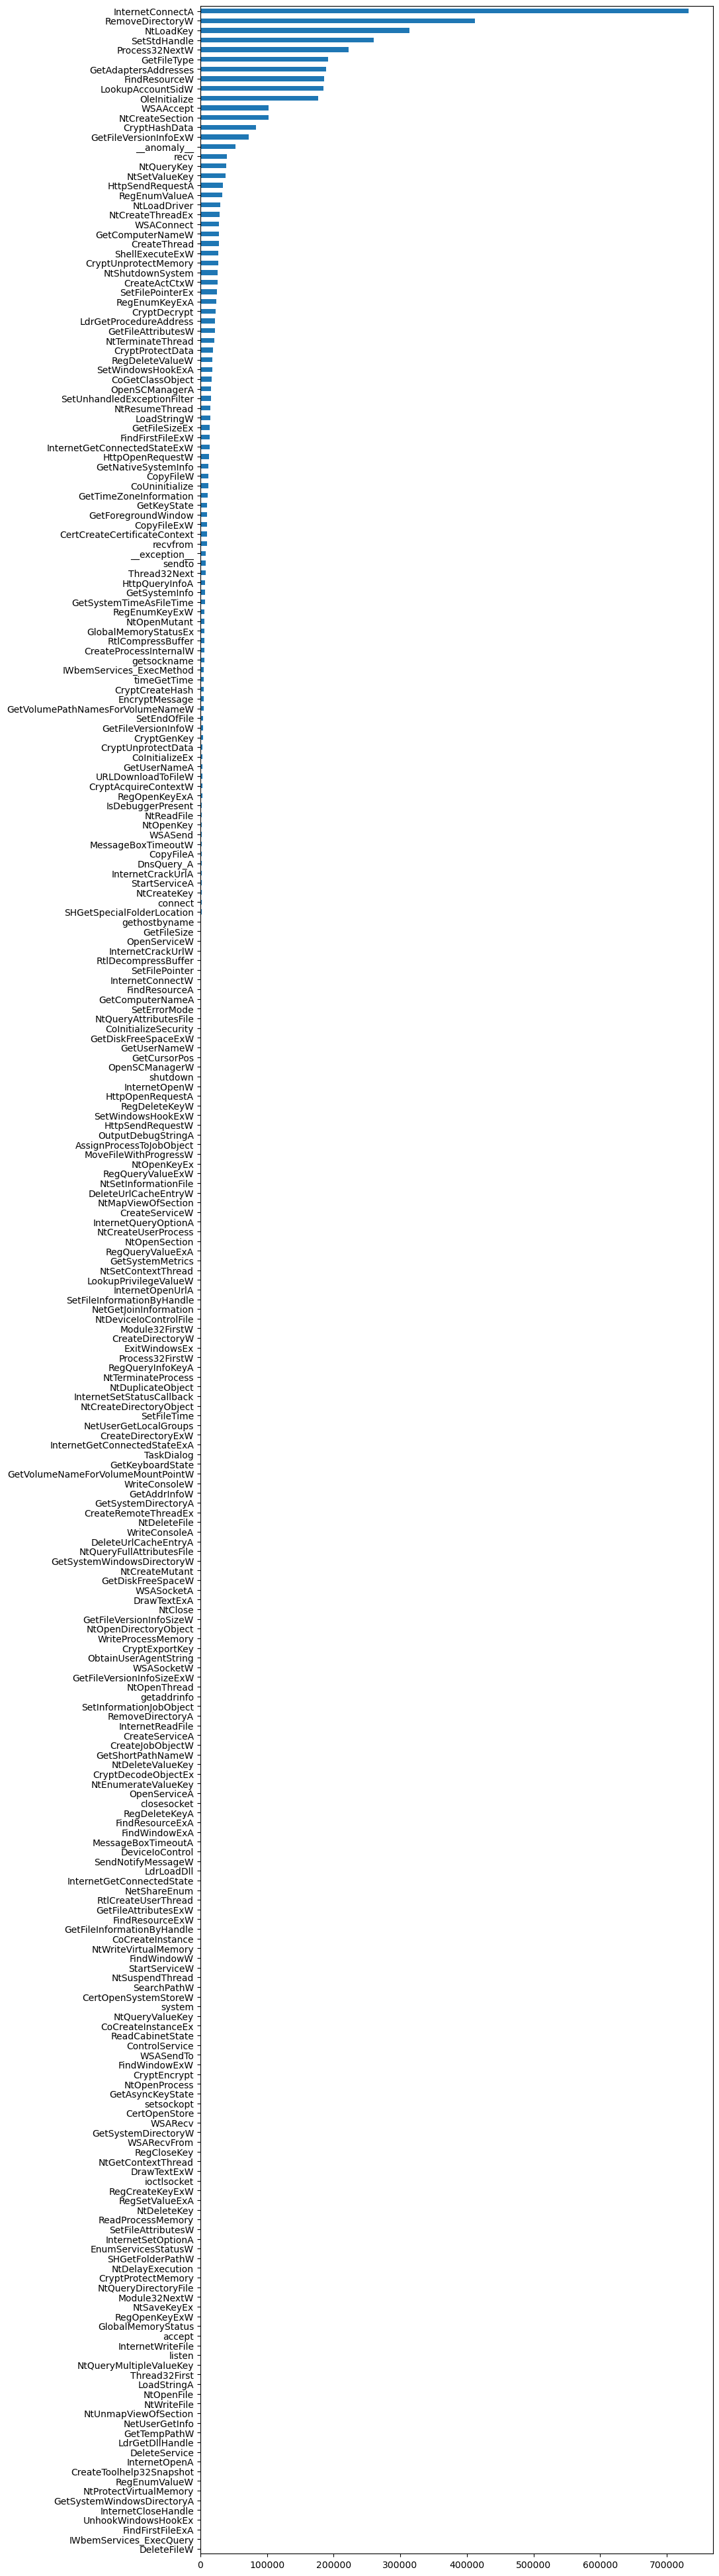

In [19]:
api_frequency = pd.DataFrame(combined_summary)[0].value_counts(ascending=True)
api_frequency.plot(kind='barh', figsize=(10,50))
print(api_frequency.to_string(), file=open('./Frequency/Olivieira_Freq.txt', mode='w'))

## 3.3. Catak (2021)

**Dataset URL:** https://github.com/ocatak/malware_api_class/

**Note:** The Catak Dataset is designed more for malware classification than detection, hence the first column for the pre-cleaned dataset is designated as a the malware type column.

### 3.3.1. Examining Raw Dataset

In [20]:
og_catak.head()

ldrloaddll ldrgetprocedureaddress ldrloaddll ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrloaddll ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrloaddll ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrloaddll ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrloaddll ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrloaddll ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrloaddll ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrloaddll ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrloaddll ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrloaddll ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrloaddll ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrgetprocedureaddress ldrg

In [21]:
og_catak = None

### 3.3.2. Pre-Cleaning Dataset

In [22]:
import threading
LABELS = []
API_CALLS = []
def read_api(dataset):
    global API_CALLS
    print("Running [read_api] thread...")
    for row in dataset:
        API_CALLS.append(row.replace("\n","").split(","))
    print("Finishing [read_api] thread...")
def read_labels(dataset_label):
    global LABELS
    print("Running [read_labels] thread...")
    for row in dataset_label:
        LABELS.append(row.replace("\n",""))
    print("Finishing [read_labels] thread...")
dataset = open("../Datasets/Catak_etal_2021/Original/all_analysis_data.csv", mode='r') #Change to: os.getcwd()+"\\Original\\"+"all_analysis_data.csv" for terminal use
dataset_label = open("../Datasets/Catak_etal_2021/Original/labels.csv", mode='r') #Change to: os.getcwd()+"\\Original\\"+"labels.csv" for terminal use
new_dataset = open("./Cache/Catak_Cleaned.csv", mode="w") #Change to: Catak_Cleaned.csv for terminal use
api_t = threading.Thread(target=read_api, args=[dataset])
label_t = threading.Thread(target=read_labels, args=[dataset_label])
api_t.start()
label_t.start()
api_t.join()
label_t.join()
print("API Calls:", len(API_CALLS))
print("Labels Size:", len(LABELS))

Running [read_api] thread...
Running [read_labels] thread...
Finishing [read_labels] thread...
Finishing [read_api] thread...
API Calls: 7107
Labels Size: 7107


**3.3.2.1 Pre-Cleaning A**

Checking for unique API calls not found on MalbehavD and Olivieira reference APIs

In [23]:
ref_apis = ['NtOpenThread', 'ExitWindowsEx', 'FindResourceW', 'CryptExportKey', 'CreateRemoteThreadEx', 'MessageBoxTimeoutW', 'InternetCrackUrlW', 'StartServiceW', 'GetFileSize', 'GetVolumeNameForVolumeMountPointW', 'GetFileInformationByHandle', 'CryptAcquireContextW', 'RtlDecompressBuffer', 'SetWindowsHookExA', 'RegSetValueExW', 'LookupAccountSidW', 'SetUnhandledExceptionFilter', 'InternetConnectA', 'GetComputerNameW', 'RegEnumValueA', 'NtOpenFile', 'NtSaveKeyEx', 'HttpOpenRequestA', 'recv', 'GetFileSizeEx', 'LoadStringW', 'SetInformationJobObject', 'WSAConnect', 'CryptDecrypt', 'GetTimeZoneInformation', 'InternetOpenW', 'CoInitializeEx', 'CryptGenKey', 'GetAsyncKeyState', 'NtQueryInformationFile', 'GetSystemMetrics', 'NtDeleteValueKey', 'NtOpenKeyEx', 'sendto', 'IsDebuggerPresent', 'RegQueryInfoKeyW', 'NetShareEnum', 'InternetOpenUrlW', 'WSASocketA', 'CopyFileExW', 'connect', 'ShellExecuteExW', 'SearchPathW', 'GetUserNameA', 'InternetOpenUrlA', 'LdrUnloadDll', 'EnumServicesStatusW', 'EnumServicesStatusA', 'WSASend', 'CopyFileW', 'NtDeleteFile', 'CreateActCtxW', 'timeGetTime', 'MessageBoxTimeoutA', 'CreateServiceA', 'FindResourceExW', 'WSAAccept', 'InternetConnectW', 'HttpSendRequestA', 'GetVolumePathNameW', 'RegCloseKey', 'InternetGetConnectedStateExW', 'GetAdaptersInfo', 'shutdown', 'NtQueryMultipleValueKey', 'NtQueryKey', 'GetSystemWindowsDirectoryW', 'GlobalMemoryStatusEx', 'GetFileAttributesExW', 'OpenServiceW', 'getsockname', 'LoadStringA', 'UnhookWindowsHookEx', 'NtCreateUserProcess', 'Process32NextW', 'CreateThread', 'LoadResource', 'GetSystemTimeAsFileTime', 'SetStdHandle', 'CoCreateInstanceEx', 'GetSystemDirectoryA', 'NtCreateMutant', 'RegCreateKeyExW', 'IWbemServices_ExecQuery', 'NtDuplicateObject', 'Thread32First', 'OpenSCManagerW', 'CreateServiceW', 'GetFileType', 'MoveFileWithProgressW', 'NtDeviceIoControlFile', 'GetFileInformationByHandleEx', 'CopyFileA', 'NtLoadKey', 'GetNativeSystemInfo', 'NtOpenProcess', 'CryptUnprotectMemory', 'InternetWriteFile', 'ReadProcessMemory', 'gethostbyname', 'WSASendTo', 'NtOpenSection', 'listen', 'WSAStartup', 'socket', 'OleInitialize', 'FindResourceA', 'RegOpenKeyExA', 'RegEnumKeyExA', 'NtQueryDirectoryFile', 'CertOpenSystemStoreW', 'ControlService', 'LdrGetProcedureAddress', 'GlobalMemoryStatus', 'NtSetInformationFile', 'OutputDebugStringA', 'GetAdaptersAddresses', 'CoInitializeSecurity', 'RegQueryValueExA', 'NtQueryFullAttributesFile', 'DeviceIoControl', '__anomaly__', 'DeleteFileW', 'GetShortPathNameW', 'NtGetContextThread', 'GetKeyboardState', 'RemoveDirectoryA', 'InternetSetStatusCallback', 'NtResumeThread', 'SetFileInformationByHandle', 'NtCreateSection', 'NtQueueApcThread', 'accept', 'DecryptMessage', 'GetUserNameExW', 'SizeofResource', 'RegQueryValueExW', 'SetWindowsHookExW', 'HttpOpenRequestW', 'CreateDirectoryW', 'InternetOpenA', 'GetFileVersionInfoExW', 'FindWindowA', 'closesocket', 'RtlAddVectoredExceptionHandler', 'IWbemServices_ExecMethod', 'GetDiskFreeSpaceExW', 'TaskDialog', 'WriteConsoleW', 'CryptEncrypt', 'WSARecvFrom', 'NtOpenMutant', 'CoGetClassObject', 'NtQueryValueKey', 'NtDelayExecution', 'select', 'HttpQueryInfoA', 'GetVolumePathNamesForVolumeNameW', 'RegDeleteValueW', 'InternetCrackUrlA', 'OpenServiceA', 'InternetSetOptionA', 'CreateDirectoryExW', 'bind', 'NtShutdownSystem', 'DeleteUrlCacheEntryA', 'NtMapViewOfSection', 'LdrGetDllHandle', 'NtCreateKey', 'GetKeyState', 'CreateRemoteThread', 'NtEnumerateValueKey', 'SetFileAttributesW', 'NtUnmapViewOfSection', 'RegDeleteValueA', 'CreateJobObjectW', 'send', 'NtDeleteKey', 'SetEndOfFile', 'GetUserNameExA', 'GetComputerNameA', 'URLDownloadToFileW', 'NtFreeVirtualMemory', 'recvfrom', 'NtUnloadDriver', 'NtTerminateThread', 'CryptUnprotectData', 'NtCreateThreadEx', 'DeleteService', 'GetFileAttributesW', 'GetFileVersionInfoSizeExW', 'OpenSCManagerA', 'WriteProcessMemory', 'GetSystemInfo', 'SetFilePointer', 'Module32FirstW', 'ioctlsocket', 'RegEnumKeyW', 'RtlCompressBuffer', 'SendNotifyMessageW', 'GetAddrInfoW', 'CryptProtectData', 'Thread32Next', 'NtAllocateVirtualMemory', 'RegEnumKeyExW', 'RegSetValueExA', 'DrawTextExA', 'CreateToolhelp32Snapshot', 'FindWindowW', 'CoUninitialize', 'NtClose', 'WSARecv', 'CertOpenStore', 'InternetGetConnectedState', 'RtlAddVectoredContinueHandler', 'RegDeleteKeyW', 'SHGetSpecialFolderLocation', 'CreateProcessInternalW', 'NtCreateDirectoryObject', 'EnumWindows', 'DrawTextExW', 'RegEnumValueW', 'SendNotifyMessageA', 'NtProtectVirtualMemory', 'NetUserGetLocalGroups', 'GetUserNameW', 'WSASocketW', 'getaddrinfo', 'AssignProcessToJobObject', 'SetFileTime', 'WriteConsoleA', 'CryptDecodeObjectEx', 'EncryptMessage', 'system', 'NtSetContextThread', 'LdrLoadDll', 'InternetGetConnectedStateExA', 'RtlCreateUserThread', 'GetCursorPos', 'Module32NextW', 'RegCreateKeyExA', 'NtLoadDriver', 'NetUserGetInfo', 'SHGetFolderPathW', 'GetBestInterfaceEx', 'CertControlStore', 'StartServiceA', 'NtWriteFile', 'Process32FirstW', 'NtReadVirtualMemory', 'GetDiskFreeSpaceW', 'GetFileVersionInfoW', 'FindFirstFileExW', 'FindWindowExW', 'GetSystemWindowsDirectoryA', 'RegOpenKeyExW', 'CoCreateInstance', 'NtQuerySystemInformation', 'LookupPrivilegeValueW', 'NtReadFile', 'ReadCabinetState', 'GetForegroundWindow', 'InternetCloseHandle', 'FindWindowExA', 'ObtainUserAgentString', 'CryptCreateHash', 'GetTempPathW', 'CryptProtectMemory', 'NetGetJoinInformation', 'NtOpenKey', 'GetSystemDirectoryW', 'DnsQuery_A', 'RegQueryInfoKeyA', 'NtEnumerateKey', 'RegisterHotKey', 'RemoveDirectoryW', 'FindFirstFileExA', 'CertOpenSystemStoreA', 'NtTerminateProcess', 'NtSetValueKey', 'CryptAcquireContextA', 'SetErrorMode', 'UuidCreate', 'RtlRemoveVectoredExceptionHandler', 'RegDeleteKeyA', 'setsockopt', 'FindResourceExA', 'NtSuspendThread', 'GetFileVersionInfoSizeW', 'NtOpenDirectoryObject', 'InternetQueryOptionA', 'InternetReadFile', 'NtCreateFile', 'NtQueryAttributesFile', 'HttpSendRequestW', 'CryptHashMessage', 'CryptHashData', 'NtWriteVirtualMemory', 'SetFilePointerEx', 'CertCreateCertificateContext', 'DeleteUrlCacheEntryW', '__exception__']
ref_apis = malbd_featr['api_calls'].tolist()
ref_apis = list(dict.fromkeys(oliveira_idx))
ref_apis.sort()
ref_apis_lower = []
for o in ref_apis:
    ref_apis_lower.append(o.lower())
unique = []
for i in range(len(LABELS)):
    sub = [LABELS[i]]
    apis = API_CALLS[i]
    for a in range(len(apis)): 
        apis[a] = apis[a].replace("\n","").split(" ")
        apis[a] = list(dict.fromkeys(apis[a]))
        for s in range(len(apis[a])):
            if apis[a][s] not in ref_apis_lower and apis[a][s] not in unique:
                unique.append(apis[a][s])
                print("Unique:", apis[a][s])
print("Catak-only APIs:", unique)
print("API Calls:", len(API_CALLS))

Unique: rtldecompressfragment
Unique: wnetgetprovidernamew
Catak-only APIs: ['rtldecompressfragment', 'wnetgetprovidernamew']
API Calls: 7107


These Catak-only APIs shall be added to the reference used for pre-cleaning Catak.

In [24]:
unique = ['RtlDecompressFragment', 'WNetGetProviderNameW']
ref_apis += unique
ref_apis_lower = []
for o in ref_apis:
    ref_apis_lower.append(o.lower())

In [25]:
sub = None
apis = None

**3.3.2.2 Pre-Cleaning B**

Converting API call casing to be the same as Oliveira's. This step also removes the repetition of API calls in the dataset as found in MalbehavD-V1 and Oliveira.

In [26]:
#CONVERTS THE CASING OF THE API CALLS IN CATAK (2021) DATASET TO THE SAME CASING AS FOUND IN OLIVEIRA (2019) AND REMOVE THE DUPLICATE API CALLS
print("API Calls:", len(API_CALLS))
print("Labels Size:", len(LABELS))
combined = []
print("Converting casing...")
for i in range(0,len(LABELS)):
    sub = [LABELS[i]]
    apis = API_CALLS[i][0]
    for a in range(len(apis)):
        apis[a] = apis[a].replace("\n","").split(" ")
        apis[a] = list(dict.fromkeys(apis[a]))
        for s in range(len(apis[a])):
            for o in range(len(ref_apis_lower)):
                if apis[a][s] in ref_apis_lower[o]:
                    sub.append(ref_apis[o])
    combined.append(sub)
print("Casing Converted")
print("Finding size of pre-cleaned dataset...")
breadth = 0
depth = len(combined)
for c in combined:
    if len(c)-1 > breadth:
        breadth = len(c)-1
print("Depth:", depth)
print("Breadth:", breadth)
header = "malware_type,malware,"
for i in range(0,breadth):
    header += str(i)
    if i < breadth-1:
        header += ","
header += "\n"
print("Writing to file...")
new_dataset.write(header)
for c in range(0,len(combined)):
    combined[c].insert(1,'1')
    new_dataset.write(','.join(combined[c])+"\n")
print("Flushing file...")
new_dataset.flush()
print("Closing file...")
new_dataset.close()
print("Pre-cleaning for Catak Completed!")
dataset = None
labels = None
new_dataset = None

API Calls: 7107
Labels Size: 7107
Converting casing...
Casing Converted
Finding size of pre-cleaned dataset...
Depth: 7107
Breadth: 166
Writing to file...
Flushing file...
Closing file...
Pre-cleaning for Catak Completed!


**3.3.2.3 Previewing Columns**

In [27]:
catak = pd.read_csv("./Cache/Catak_Cleaned.csv", low_memory=False)
catak.head()

,malware_type,malware,0,1,2,3,4,5,6,7,...,156,157,158,159,160,161,162,163,164,165
0,Trojan,1,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExA,NtOpenKey,NtOpenKeyEx,NtQueryValueKey,NtClose,NtQueryAttributesFile,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Trojan,1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,SetUnhandledExceptionFilter,NtCreateMutant,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Backdoor,1,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemDirectoryA,CopyFileA,RegOpenKeyExA,RegSetValueExA,RegCloseKey,RegCreateKeyExA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Backdoor,1,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExA,NtOpenKey,NtOpenKeyEx,NtQueryValueKey,NtClose,NtQueryAttributesFile,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Trojan,1,LdrLoadDll,LdrGetProcedureAddress,WSAStartup,NtCreateMutant,RegOpenKeyExA,RegDeleteKeyA,RegCloseKey,CopyFileA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.3.3. Examining API calls

**3.3.3.1. Examining API calls in Catak**

In [28]:
featr = catak.iloc[:,2:]
featr.head()

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,161,162,163,164,165
0,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExA,NtOpenKey,NtOpenKeyEx,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,SetUnhandledExceptionFilter,NtCreateMutant,NtClose,LdrLoadDll,GetSystemInfo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemDirectoryA,CopyFileA,RegOpenKeyExA,RegSetValueExA,RegCloseKey,RegCreateKeyExA,NtCreateFile,SetFilePointer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExA,NtOpenKey,NtOpenKeyEx,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LdrLoadDll,LdrGetProcedureAddress,WSAStartup,NtCreateMutant,RegOpenKeyExA,RegDeleteKeyA,RegCloseKey,CopyFileA,RegSetValueExA,NtCreateFile,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**3.3.3.2. Unique API calls on Catak**

In [29]:
combined_summary = []
featr['summary'] = featr.values.tolist()
for i in range(featr['summary'].shape[0]):
    length = len(featr['summary'].loc[i])
    for j in range(length-1):
        combined_summary.append(featr['summary'].loc[i][j])
print("combined_summary:", len(combined_summary))
catak_featr = pd.Series(combined_summary).dropna().drop_duplicates().reset_index()
catak_featr.rename(columns={'index': 'index', 0: 'api_calls'}, inplace=True)
catak_featr.sort_values(inplace=True, by='api_calls')
catak_featr.drop(axis=1, labels="index", inplace=True)

#Writing to own file
f = open("./Features/Catak_Features.txt", mode="w")
f.write(str(catak_featr['api_calls'].tolist()).replace('[','').replace(']','').replace(',','\n').replace('\'','').replace(' ',''))
f.flush()
f.close()

catak_featr.head()

combined_summary: 1172655


,api_calls
184,CertOpenSystemStoreA
115,CoCreateInstance
116,CoCreateInstanceEx
149,CoGetClassObject
27,CoInitializeEx


**3.3.3.3. Frquency of API calls in the Dataset**

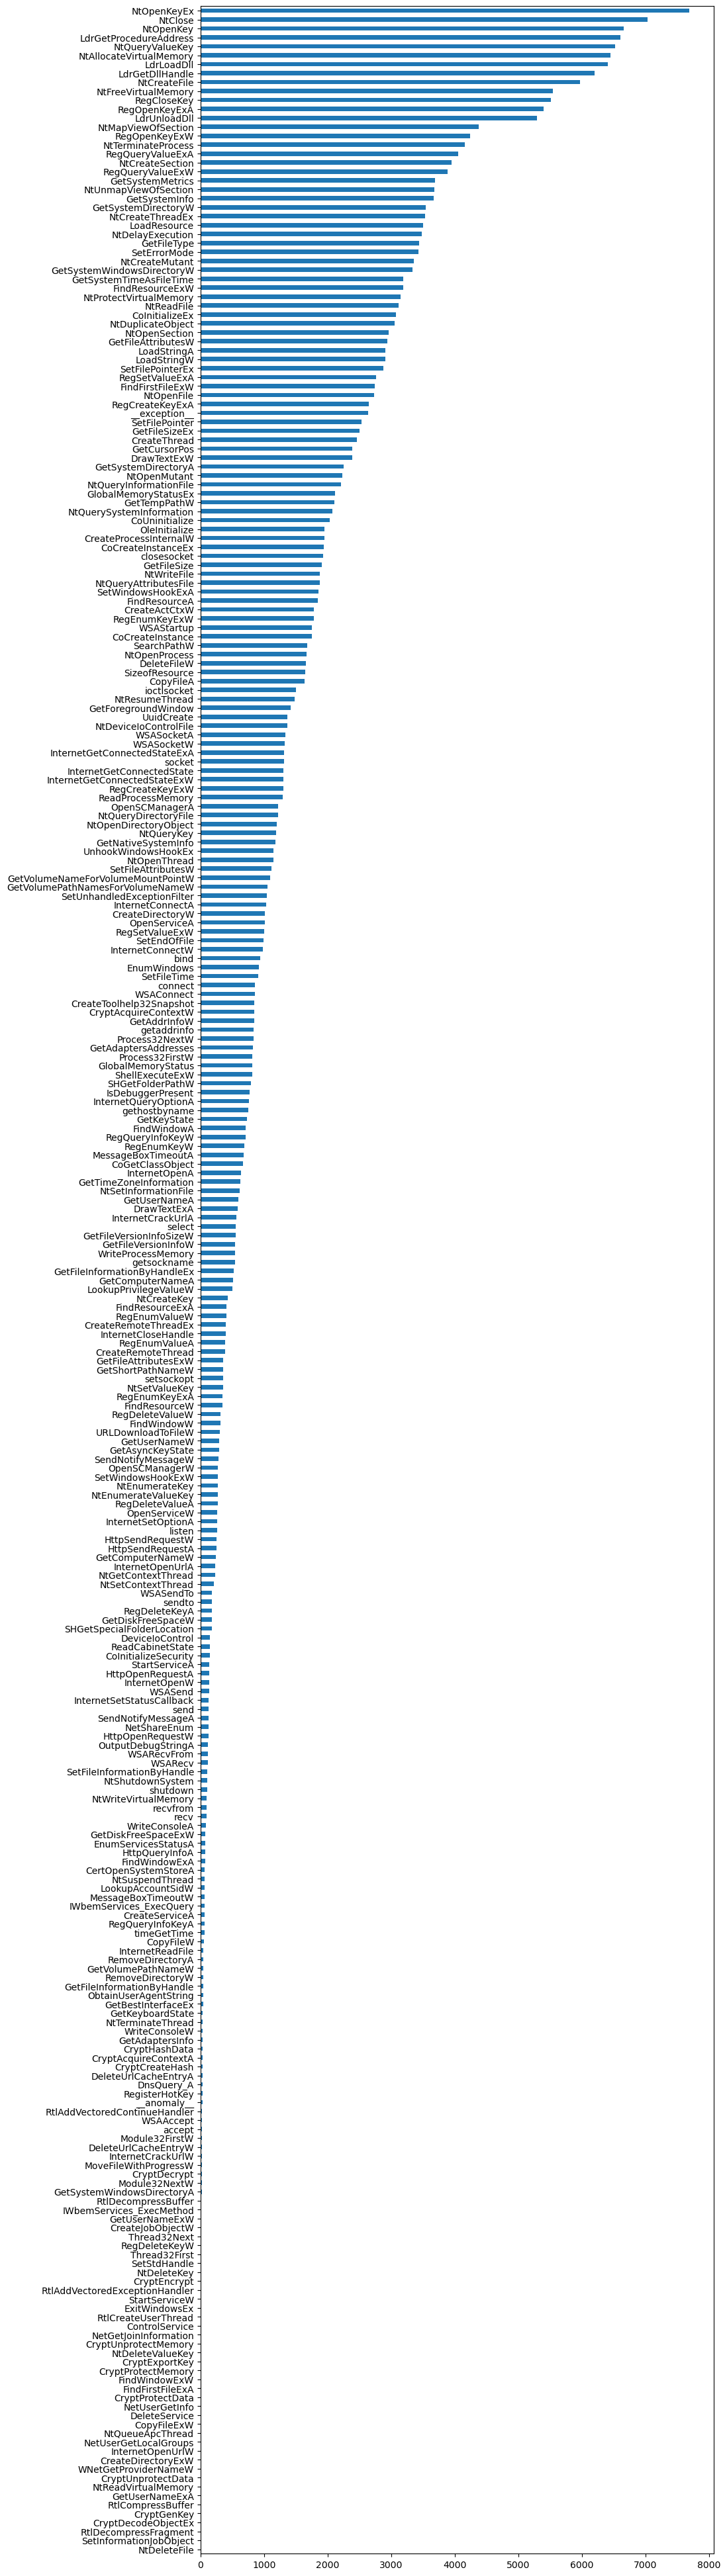

In [30]:
api_frequency = pd.DataFrame(combined_summary)[0].value_counts(ascending=True)
api_frequency.plot(kind='barh', figsize=(10,50))
print(api_frequency.to_string(), file=open('./Frequency/Catak_Freq.txt', mode='w'))

# 4. Comparing MalbehavD-V1 to Oliveira and Catak Datasets

## 4.1. Finding API call similarity in MalbehavD-V1 from Oliveira and Catak Datasets

Determining the similarities of MalbehavD-V1 to its counterparts, Oliveira and Catak.

In [31]:
def find_match(src:list, other:list):
    score = 0
    for m in src:
        if m in other:
            score += 1
    return 100*(score/len(src))

oli_apis = oli_featr['api_calls'].tolist()
catak_apis = catak_featr['api_calls'].tolist()
malbd_apis = malbd_featr['api_calls'].tolist()
malbd_oli_catak_featr = {'malbehavd_api':malbd_featr['api_calls'].tolist(), 
                         'match_to_oliveira': malbd_featr['api_calls'].isin(oli_apis).tolist(),
                         'match_to_catak': malbd_featr['api_calls'].isin(catak_apis).tolist()}
malbd_oli_catak_featr = pd.DataFrame(data=malbd_oli_catak_featr)
malbd_oli_catak_featr.to_csv("./Matching/MalbehavD_Match.csv", index=False)
print(f"MalbehavD-V1 to Oliveira Match Rate: {find_match(malbd_apis, oli_apis):.4f}%")
print(f"MalbehavD-V1 to Catak Match Rate: {find_match(malbd_apis, catak_apis):.4f}%")
malbd_oli_catak_featr

MalbehavD-V1 to Oliveira Match Rate: 85.5670%
MalbehavD-V1 to Catak Match Rate: 93.4708%


,malbehavd_api,match_to_oliveira,match_to_catak
0,CertControlStore,False,False
1,CertCreateCertificateContext,True,False
2,CertOpenStore,True,False
3,CertOpenSystemStoreW,True,False
4,CoCreateInstance,True,True
...,...,...,...
286,sendto,True,True
287,setsockopt,True,True
288,shutdown,True,True
289,socket,False,True


**Conclusion:**

The nearest alternative dataset to MalbehavD-V1 is Catak with a match rate of 93.47% (i.e., similarity of APIs found between the datasets).

## 4.2. Finding API call similarity of each dataset (MalbehavD-V1, Oliveira, & Catak) to all combined unique API calls.

Combining all unique APIs on all dataset and determinining how much of these API calls are found in a specified dataset.

In [32]:
def find_true_rate(exists:list):
    count = 0
    for e in exists:
        if str(e) == "True":
            count += 1
    return 100*(count/len(exists))
all_apis = malbd_apis + oli_apis + catak_apis
all_apis = list(dict.fromkeys(all_apis))
results = []
for api in all_apis:
    results.append(api+","+str(api in malbd_apis)+","+str(api in oli_apis)+","+str(api in catak_apis))
receipt = open("CombinedAPIs.csv", mode="w")
receipt.write("api,inMalbehavD,inOliveira,inCatak"+"\n")
for r in results:
    receipt.write(r+"\n")
receipt.flush()
receipt.close()
combined_apis = pd.read_csv("CombinedAPIs.csv")
print(f"Combined APIs in MalbehavD: {find_true_rate(combined_apis['inMalbehavD'].tolist()):.2f}%")
print(f"Combined APIs in Oliviera: {find_true_rate(combined_apis['inOliveira'].tolist()):.2f}%")
print(f"Combined APIs in Catak: {find_true_rate(combined_apis['inCatak'].tolist()):.2f}%")
combined_apis

Combined APIs in MalbehavD: 94.48%
Combined APIs in Oliviera: 85.39%
Combined APIs in Catak: 92.53%


,api,inMalbehavD,inOliveira,inCatak
0,CertControlStore,True,False,False
1,CertCreateCertificateContext,True,True,False
2,CertOpenStore,True,True,False
3,CertOpenSystemStoreW,True,True,False
4,CoCreateInstance,True,True,True
...,...,...,...,...
303,__anomaly__,False,True,True
304,system,False,True,False
305,CertOpenSystemStoreA,False,False,True
306,RtlDecompressFragment,False,False,True


**Conclusion:**

It can be assumed then that **MalbehavD does indeed have the most number of APIs** that is found across all three datasets. Hence, it is rightful that it will be the selected dataset as the training dataset while the rest will only be suitable for use as test datasets (especially in the context of reliability).

However, due to the problem at hand being an ML problem, there might be still advantages on utilizing Oliveira instead of MalbehavD due to the prior's advantage in terms of quantity despite being marginally lower in terms of quality. This assumption however can only be seen once there is a pre-testing of the dataset on a set of test ML models.

# 5. Converting string features to int features

The technique to be used here will be [**LabelEncoder**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

Basically what it does it converts string API calls to numeric equivalent.

This however means that the deployed model will require on the 'transformed' values as per the APIs listed in the `CombinedAPIs.csv` with an included `'nan'` value which is referred to in the notebook as `apis`.

## 5.1 Getting Reference APIs

For use later when transforming data from string APIs to numeric form to be compatible for use in ML training.

In [33]:
def getAPIs():
    apis = pd.read_csv('CombinedAPIs.csv', low_memory=False)
    apis = apis['api'].to_list()
    apis.append('nan') #Take note of this
    return apis

apis = getAPIs()
apis

['CertControlStore',
 'CertCreateCertificateContext',
 'CertOpenStore',
 'CertOpenSystemStoreW',
 'CoCreateInstance',
 'CoCreateInstanceEx',
 'CoGetClassObject',
 'CoInitializeEx',
 'CoInitializeSecurity',
 'CoUninitialize',
 'ControlService',
 'CopyFileA',
 'CopyFileExW',
 'CopyFileW',
 'CreateActCtxW',
 'CreateDirectoryExW',
 'CreateDirectoryW',
 'CreateJobObjectW',
 'CreateProcessInternalW',
 'CreateRemoteThread',
 'CreateServiceA',
 'CreateServiceW',
 'CreateThread',
 'CreateToolhelp32Snapshot',
 'CryptAcquireContextA',
 'CryptAcquireContextW',
 'CryptCreateHash',
 'CryptDecodeObjectEx',
 'CryptDecrypt',
 'CryptEncrypt',
 'CryptExportKey',
 'CryptGenKey',
 'CryptHashData',
 'CryptProtectData',
 'CryptProtectMemory',
 'CryptUnprotectData',
 'CryptUnprotectMemory',
 'DecryptMessage',
 'DeleteFileW',
 'DeleteUrlCacheEntryA',
 'DeleteUrlCacheEntryW',
 'DeviceIoControl',
 'DnsQuery_A',
 'DnsQuery_W',
 'DrawTextExA',
 'DrawTextExW',
 'EncryptMessage',
 'EnumServicesStatusA',
 'EnumServic

## 5.2. Loading LabelEncoder

The technique to be used here will be [**LabelEncoder**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [34]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(apis)

LabelEncoder()

## 5.3. MalbehavD-V1

### 5.3.1 Reading CSV file

In [35]:
malbehavd = pd.read_csv('MalbehavD_Str.csv', low_memory=False)
malbehavd.head()

,sha256,malware,0,1,2,3,4,5,6,7,...,165,166,167,168,169,170,171,172,173,174
0,5c18291c481a192ed5003084dab2d8a117fd3736359218...,0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4683faf3da550ffb594cf5513c4cbb34f64df85f27fd1c...,0,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9a0aea1c7290031d7c3429d0e921f107282cc6eab854ee...,0,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e0f3e4d5f50afd9c31e51dd9941c5a52d57c7c524f5d11...,0,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ec2b6d29992f13e74015ff0b129150b4afae15c593e4b7...,0,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 5.3.2. Checking APIs

In [36]:
malbehavd_feats = []
for i in range(malbehavd.shape[1]-2):
    malbehavd_feats.append(str(i))
malbehavd[malbehavd_feats].head()

,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtClose,GetFileVersionInfoSizeW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,NtQueryValueKey,RegCloseKey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,RegQueryValueExW,NtMapViewOfSection,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,LdrGetDllHandle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,NtQueryAttributesFile,LdrGetDllHandle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 5.3.3. Transforming string API calls to int equivalent 

In [37]:
for f in malbehavd_feats:
    malbehavd[f] = pd.Series(le.fit_transform(malbehavd[f]))
X = malbehavd[malbehavd_feats]
malbehavd[malbehavd_feats].head()

,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
0,26,2,65,52,29,31,44,37,63,31,...,1,1,1,1,1,1,1,1,1,1
1,35,19,65,9,78,92,46,1,85,98,...,1,1,1,1,1,1,1,1,1,1
2,14,7,26,35,34,77,94,22,105,73,...,1,1,1,1,1,1,1,1,1,1
3,39,31,35,95,66,43,85,54,62,48,...,1,1,1,1,1,1,1,1,1,1
4,26,23,60,94,104,83,56,53,81,48,...,1,1,1,1,1,1,1,1,1,1


### 5.3.4 Saving conversion to file

In [38]:
malbehavd.to_csv("MalbehavD_LabelEncoded.csv", index=False)

## 5.4. Catak

### 5.4.1 Reading CSV file

In [39]:
catak = pd.read_csv('Catak_Str.csv', low_memory=False)
catak.head()

,malware_type,malware,0,1,2,3,4,5,6,7,...,156,157,158,159,160,161,162,163,164,165
0,Trojan,1,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExA,NtOpenKey,NtOpenKeyEx,NtQueryValueKey,NtClose,NtQueryAttributesFile,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Trojan,1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,SetUnhandledExceptionFilter,NtCreateMutant,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Backdoor,1,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemDirectoryA,CopyFileA,RegOpenKeyExA,RegSetValueExA,RegCloseKey,RegCreateKeyExA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Backdoor,1,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExA,NtOpenKey,NtOpenKeyEx,NtQueryValueKey,NtClose,NtQueryAttributesFile,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Trojan,1,LdrLoadDll,LdrGetProcedureAddress,WSAStartup,NtCreateMutant,RegOpenKeyExA,RegDeleteKeyA,RegCloseKey,CopyFileA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 5.4.2. Checking APIs

In [40]:
catak_feats = []
for i in range(catak.shape[1]-2):
    catak_feats.append(str(i))
catak[catak_feats].head()

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,161,162,163,164,165
0,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExA,NtOpenKey,NtOpenKeyEx,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,SetUnhandledExceptionFilter,NtCreateMutant,NtClose,LdrLoadDll,GetSystemInfo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemDirectoryA,CopyFileA,RegOpenKeyExA,RegSetValueExA,RegCloseKey,RegCreateKeyExA,NtCreateFile,SetFilePointer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExA,NtOpenKey,NtOpenKeyEx,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LdrLoadDll,LdrGetProcedureAddress,WSAStartup,NtCreateMutant,RegOpenKeyExA,RegDeleteKeyA,RegCloseKey,CopyFileA,RegSetValueExA,NtCreateFile,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 5.4.3. Transforming string API calls to int equivalent 

In [41]:
for f in catak_feats:
    catak[f] = pd.Series(le.fit_transform(catak[f]))
X = catak[catak_feats]
catak[catak_feats].head()

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,161,162,163,164,165
0,27,32,87,66,71,84,64,75,49,61,...,6,3,4,3,2,2,2,2,1,1
1,19,39,54,41,45,118,67,54,46,38,...,6,3,4,3,2,2,2,2,1,1
2,25,32,22,2,99,109,106,96,57,121,...,6,3,4,3,2,2,2,2,1,1
3,27,32,87,66,71,84,64,75,49,61,...,6,3,4,3,2,2,2,2,1,1
4,27,32,106,55,99,101,106,4,108,63,...,6,3,4,3,2,2,2,2,1,1


### 5.4.4 Saving conversion to file

In [42]:
catak.to_csv("Catak_LabelEncoded.csv", index=False)

## 5.5. Oliveira

### 5.5.1 Reading CSV file

In [43]:
oliveira = pd.read_csv('Oliveira_Str.csv', low_memory=False)
oliveira.head()

,hash,malware,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,071e8c3f8922e186e57548cd4c703a5d,1,HttpSendRequestA,WSAAccept,NtCreateSection,Process32NextW,WSAAccept,NtCreateSection,Process32NextW,recvfrom,...,InternetConnectA,GetComputerNameW,recv,LdrGetProcedureAddress,NtLoadDriver,Process32NextW,CryptHashData,OleInitialize,FindFirstFileExW,GetComputerNameW
1,33f8e6d08a6aae939f25a8e0d63dd523,1,GetFileVersionInfoExW,OleInitialize,NtQueryKey,OleInitialize,NtLoadKey,InternetConnectA,NtLoadKey,InternetConnectA,...,FindResourceW,GetFileType,RemoveDirectoryW,InternetConnectA,GetComputerNameW,recv,LdrGetProcedureAddress,NtLoadDriver,Process32NextW,CryptHashData
2,b68abd064e975e1c6d5f25e748663076,1,CreateActCtxW,HttpOpenRequestW,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,...,InternetGetConnectedStateExW,GetAdaptersAddresses,HttpSendRequestA,InternetGetConnectedStateExW,GetAdaptersAddresses,HttpSendRequestA,InternetGetConnectedStateExW,GetAdaptersAddresses,HttpSendRequestW,HttpSendRequestA
3,72049be7bd30ea61297ea624ae198067,1,GetFileVersionInfoExW,OleInitialize,NtQueryKey,OleInitialize,NtLoadKey,InternetConnectA,NtLoadKey,InternetConnectA,...,Process32NextW,OleInitialize,setsockopt,OleInitialize,setsockopt,NtQueryKey,OleInitialize,setsockopt,RegEnumValueA,setsockopt
4,c9b3700a77facf29172f32df6bc77f48,1,GetFileVersionInfoExW,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,...,CryptUnprotectMemory,OpenSCManagerA,SetStdHandle,CryptUnprotectMemory,OpenSCManagerA,SetStdHandle,LookupAccountSidW,SetStdHandle,LookupAccountSidW,SetStdHandle


### 5.5.2. Checking APIs

In [44]:
oliveira_feats = []
for i in range(oliveira.shape[1]-2):
    oliveira_feats.append(str(i))
oliveira[oliveira_feats].head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,HttpSendRequestA,WSAAccept,NtCreateSection,Process32NextW,WSAAccept,NtCreateSection,Process32NextW,recvfrom,GetFileAttributesW,OleInitialize,...,InternetConnectA,GetComputerNameW,recv,LdrGetProcedureAddress,NtLoadDriver,Process32NextW,CryptHashData,OleInitialize,FindFirstFileExW,GetComputerNameW
1,GetFileVersionInfoExW,OleInitialize,NtQueryKey,OleInitialize,NtLoadKey,InternetConnectA,NtLoadKey,InternetConnectA,NtLoadKey,InternetConnectA,...,FindResourceW,GetFileType,RemoveDirectoryW,InternetConnectA,GetComputerNameW,recv,LdrGetProcedureAddress,NtLoadDriver,Process32NextW,CryptHashData
2,CreateActCtxW,HttpOpenRequestW,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,...,InternetGetConnectedStateExW,GetAdaptersAddresses,HttpSendRequestA,InternetGetConnectedStateExW,GetAdaptersAddresses,HttpSendRequestA,InternetGetConnectedStateExW,GetAdaptersAddresses,HttpSendRequestW,HttpSendRequestA
3,GetFileVersionInfoExW,OleInitialize,NtQueryKey,OleInitialize,NtLoadKey,InternetConnectA,NtLoadKey,InternetConnectA,NtLoadKey,InternetConnectA,...,Process32NextW,OleInitialize,setsockopt,OleInitialize,setsockopt,NtQueryKey,OleInitialize,setsockopt,RegEnumValueA,setsockopt
4,GetFileVersionInfoExW,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,RemoveDirectoryW,InternetConnectA,NtLoadKey,...,CryptUnprotectMemory,OpenSCManagerA,SetStdHandle,CryptUnprotectMemory,OpenSCManagerA,SetStdHandle,LookupAccountSidW,SetStdHandle,LookupAccountSidW,SetStdHandle


### 5.5.3. Transforming string API calls to int equivalent 

In [45]:
for f in oliveira_feats:
    oliveira[f] = pd.Series(le.fit_transform(oliveira[f]))
X = oliveira[oliveira_feats]
oliveira[oliveira_feats].head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,36,74,54,68,108,71,91,123,32,88,...,73,41,177,83,103,126,23,128,34,40
1,22,54,62,65,71,54,75,52,76,53,...,35,49,143,72,42,174,85,110,135,23
2,3,32,75,43,92,54,97,52,96,53,...,77,39,72,77,39,68,79,41,73,69
3,22,54,62,65,71,54,75,52,76,53,...,129,122,180,126,182,109,128,185,141,177
4,22,63,42,74,51,98,56,96,55,76,...,26,123,153,26,125,152,88,159,90,152


### 5.5.4 Saving conversion to file

In [46]:
oliveira.to_csv("Oliveira_LabelEncoded.csv", index=False)

# 6. Final Cleaning

## 6.1. Identifying Min & Max Feature Size/Breadth

In [47]:
#Note: The -2 is for the first two columns which are non-API related (i.e., label)
datasets = [malbehavd, oliveira, catak]
dataset_label = ["MalbehavD", "Oliveira","Catak"]
lowest = 1000
highest = 0
for d in range(len(datasets)):
    print(f"{dataset_label[d]} Features (APIs only): {datasets[d].shape[1]-2}")
    if datasets[d].shape[1]-2 > highest:
        highest = datasets[d].shape[1]-2
print("")
print(f"Set Highest Feature Size: {highest}")
print(f"Set Lowest Feature Size: {lowest}")

MalbehavD Features (APIs only): 175
Oliveira Features (APIs only): 100
Catak Features (APIs only): 166

Set Highest Feature Size: 175
Set Lowest Feature Size: 1000


## 6.2. Maximizing Features/Breadth

Maximizing no. features to the dataset with lowest feature set count (only APIs) to avoid error:

`The feature names should match those that were passed during fit. Feature names seen at fit time, yet now missing`

This error only occurs whenever the fitted features of the training data is more than the features of the test data which can occur during Model Robustness Testing.

Reference max no. of features will be from MalbehavD with 175 API calls.

### 6.2.1 Shaping Oliveira to same breadth as MalbehavD

In [48]:
#Building missing columns for Oliveira
depth = oliveira.shape[0]
breadth = oliveira.shape[1]-2
missing_header = []
for i in range(0, highest-oliveira.shape[1]+2):
    missing_header.append(breadth+i)
extension_oli = pd.DataFrame(1, index = np.arange(depth), columns = missing_header)
oliveira_max = oliveira.join(extension_oli)

### 6.2.2 Shaping Catak to same breadth as MalbehavD

In [49]:
#Building missing columns for Oliveira
depth = catak.shape[0]
breadth = catak.shape[1]-2
missing_header = []
for i in range(0, highest-catak.shape[1]+2):
    missing_header.append(breadth+i)
extension_catak = pd.DataFrame(1, index = np.arange(depth), columns = missing_header)
catak_max = catak.join(extension_catak)

## 6.3. Saving Label Encoded & Trimmed Dataset (i.e., Final Clean A)

In [50]:
print("Saving DFs as CSV files...")
catak_max.to_csv("Catak_LabelEnc_Max.csv", index=False)
oliveira_max.to_csv("Oliveira_LabelEnc_Max.csv", index=False)
malbehavd.to_csv("MalbehavD_LabelEnc_Max.csv", index=False)
print("Saving completed!")

Saving DFs as CSV files...
Saving completed!


## 6.4. Trimming Features/Breadth

Trimming no. features to the dataset with lowest feature set count (only APIs) to avoid error:

`The feature names should match those that were passed during fit.`

This error only occurs whenever the fitted features of the training data is  less than the features of the test data which can occur during Model Robustness Testing. 

In [51]:
#Note: The -2 is for the first two columns which are non-API related (i.e., label)
datasets = [malbehavd, oliveira, catak]
dataset_label = ["MalbehavD", "Oliveira","Catak"]
lowest = 1000
for d in range(len(datasets)):
    print(f"{dataset_label[d]} Features (APIs only): {datasets[d].shape[1]-2}")
    if datasets[d].shape[1]-2 < lowest:
        lowest = datasets[d].shape[1]-2
print(f"Set Lowest Feature Size: {lowest}")

MalbehavD Features (APIs only): 175
Oliveira Features (APIs only): 100
Catak Features (APIs only): 166
Set Lowest Feature Size: 100


### 6.4.1 Dropping excess from MalbehavD

In [52]:
malbehavd_dropped = malbehavd.drop(malbehavd.columns[lowest-1+3:],axis=1,inplace=False)
malbehavd_dropped.head()

,sha256,malware,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,5c18291c481a192ed5003084dab2d8a117fd3736359218...,0,26,2,65,52,29,31,44,37,...,99,97,94,86,95,89,83,83,80,74
1,4683faf3da550ffb594cf5513c4cbb34f64df85f27fd1c...,0,35,19,65,9,78,92,46,1,...,99,97,94,86,95,89,83,83,80,74
2,9a0aea1c7290031d7c3429d0e921f107282cc6eab854ee...,0,14,7,26,35,34,77,94,22,...,99,97,94,86,95,89,83,83,80,74
3,e0f3e4d5f50afd9c31e51dd9941c5a52d57c7c524f5d11...,0,39,31,35,95,66,43,85,54,...,99,97,94,86,95,89,83,83,80,74
4,ec2b6d29992f13e74015ff0b129150b4afae15c593e4b7...,0,26,23,60,94,104,83,56,53,...,99,97,94,86,95,89,83,83,80,74


### 6.4.2 Dropping excess from Catak

In [53]:
catak_dropped = catak.drop(catak.columns[lowest-1+3:],axis=1)
catak_dropped.head()

,malware_type,malware,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,Trojan,1,27,32,87,66,71,84,64,75,...,112,108,111,108,103,100,94,97,93,87
1,Trojan,1,19,39,54,41,45,118,67,54,...,112,108,111,108,103,100,94,97,93,87
2,Backdoor,1,25,32,22,2,99,109,106,96,...,112,108,111,108,103,100,94,97,93,87
3,Backdoor,1,27,32,87,66,71,84,64,75,...,112,108,111,108,103,100,94,97,93,87
4,Trojan,1,27,32,106,55,99,101,106,4,...,112,108,111,108,103,100,94,97,93,87


## 6.5. Saving Label Encoded & Trimmed Dataset (i.e., Final Clean B)

In [54]:
print("Saving DFs as CSV files...")
catak_dropped.to_csv("Catak_LabelEnc_Trim.csv", index=False)
oliveira.to_csv("Oliveira_LabelEnc_Trim.csv", index=False)
malbehavd_dropped.to_csv("MalbehavD_LabelEnc_Trim.csv", index=False)
print("Saving completed!")

Saving DFs as CSV files...
Saving completed!


# 7. Time Taken

In [55]:
dur_s = time.time()-start_time
dur_min = dur_s/60
print(f"{dur_s}s")
print(f"{dur_min:.2f}mins")

351.49601697921753s
5.86mins
